In [ ]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import drop_path, to_2tuple, trunc_normal_
from timm.models.layers import trunc_normal_ as __call_trunc_normal_
from timm.models.registry import register_model
import torch.utils.checkpoint as checkpoint
import math

def pretrain_trunc_normal_(tensor, mean=0., std=1.):
    __call_trunc_normal_(tensor, mean=mean, std=std, a=-std, b=std)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 400, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5),
        **kwargs
    }


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # commit this for the orignal BERT implement 
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, attn_head_dim=attn_head_dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values > 0:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, num_frames=16, tubelet_size=2):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.tubelet_size = int(tubelet_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) * (num_frames // self.tubelet_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv3d(in_channels=in_chans, out_channels=embed_dim, 
                            kernel_size = (self.tubelet_size,  patch_size[0],patch_size[1]), 
                            stride=(self.tubelet_size,  patch_size[0],  patch_size[1]))

    def forward(self, x, **kwargs):
        B, C, T, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x
    
# sin-cos position encoding
# https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Models.py#L31
def get_sinusoid_encoding_table(n_position, d_hid): 
    ''' Sinusoid position encoding table ''' 
    # TODO: make it with torch instead of numpy 
    def get_position_angle_vec(position): 
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)] 

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)]) 
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # dim 2i 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # dim 2i+1 

    return  torch.tensor(sinusoid_table,dtype=torch.float, requires_grad=False).unsqueeze(0) 


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, 
                 img_size=224, 
                 patch_size=16, 
                 in_chans=3, 
                 num_classes=1000, 
                 embed_dim=768, 
                 depth=12,
                 num_heads=12, 
                 mlp_ratio=4., 
                 qkv_bias=False, 
                 qk_scale=None, 
                 fc_drop_rate=0., 
                 drop_rate=0., 
                 attn_drop_rate=0.,
                 drop_path_rate=0., 
                 norm_layer=nn.LayerNorm, 
                 init_values=0.,
                 use_learnable_pos_emb=False, 
                 init_scale=0.,
                 all_frames=16,
                 tubelet_size=2,
                 use_checkpoint=False,
                 use_mean_pooling=True):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.tubelet_size = tubelet_size
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, num_frames=all_frames, tubelet_size=self.tubelet_size)
        num_patches = self.patch_embed.num_patches
        self.use_checkpoint = use_checkpoint

        if use_learnable_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        else:
            # sine-cosine positional embeddings is on the way
            self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        self.pos_drop = nn.Dropout(p=drop_rate)


        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm = nn.Identity() if use_mean_pooling else norm_layer(embed_dim)
        self.fc_norm = norm_layer(embed_dim) if use_mean_pooling else None
        self.fc_dropout = nn.Dropout(p=fc_drop_rate) if fc_drop_rate > 0 else nn.Identity()
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if use_learnable_pos_emb:
            pretrain_trunc_normal_(self.pos_embed, std=.02)

        pretrain_trunc_normal_(self.head.weight, std=.02)
        self.apply(self._init_weights)

        self.head.weight.data.mul_(init_scale)
        self.head.bias.data.mul_(init_scale)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            pretrain_trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        B, _, _ = x.size()

        if self.pos_embed is not None:
            x = x + self.pos_embed.expand(B, -1, -1).type_as(x).to(x.device).clone().detach()
        x = self.pos_drop(x)

        if self.use_checkpoint:
            for blk in self.blocks:
                x = checkpoint.checkpoint(blk, x)
        else:   
            for blk in self.blocks:
                x = blk(x)

        x = self.norm(x)
        if self.fc_norm is not None:
            return self.fc_norm(x.mean(1))
        else:
            return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(self.fc_dropout(x))
        return x


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_512(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=512, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model

class PretrainVisionTransformerEncoder(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None, tubelet_size=2, use_checkpoint=False,
                 use_learnable_pos_emb=False):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,tubelet_size=tubelet_size)
        num_patches = self.patch_embed.num_patches
        self.use_checkpoint = use_checkpoint


        # TODO: Add the cls token
        if use_learnable_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        else:
            # sine-cosine positional embeddings 
            self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm =  norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if use_learnable_pos_emb:
            pretrain_trunc_normal_(self.pos_embed, std=.02)

        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        _, _, T, _, _ = x.shape
        x = self.patch_embed(x)
        
        x = x + self.pos_embed.type_as(x).to(x.device).clone().detach()

        B, _, C = x.shape
        x_vis = x.reshape(B, -1, C) # ~mask means visible

        if self.use_checkpoint:
            for blk in self.blocks:
                x_vis = checkpoint.checkpoint(blk, x_vis)
        else:   
            for blk in self.blocks:
                x_vis = blk(x_vis)

        x_vis = self.norm(x_vis)
        return x_vis

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

class PretrainVisionTransformerDecoder(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, patch_size=16, num_classes=768, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 norm_layer=nn.LayerNorm, init_values=None, num_patches=196, tubelet_size=2, use_checkpoint=False
                 ):
        super().__init__()
        self.num_classes = num_classes
        assert num_classes == 3 * tubelet_size * patch_size ** 2 
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_size = patch_size
        self.use_checkpoint = use_checkpoint


        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm =  norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x, return_token_num):
        if self.use_checkpoint:
            for blk in self.blocks:
                x = checkpoint.checkpoint(blk, x)
        else:   
            for blk in self.blocks:
                x = blk(x)

        if return_token_num > 0:
            x = self.head(self.norm(x[:, -return_token_num:])) # only return the mask tokens predict pixels
        else:
            x = self.head(self.norm(x))

        return x

class PretrainVisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self,
                 img_size=224, 
                 patch_size=16, 
                 encoder_in_chans=3, 
                 encoder_num_classes=0, 
                 encoder_embed_dim=768, 
                 encoder_depth=12,
                 encoder_num_heads=12, 
                 decoder_num_classes=1536, #  decoder_num_classes=768, 
                 decoder_embed_dim=512, 
                 decoder_depth=8,
                 decoder_num_heads=8, 
                 mlp_ratio=4., 
                 qkv_bias=False, 
                 qk_scale=None, 
                 drop_rate=0., 
                 attn_drop_rate=0.,
                 drop_path_rate=0., 
                 norm_layer=nn.LayerNorm, 
                 init_values=0.,
                 use_learnable_pos_emb=False,
                 use_checkpoint=False,
                 tubelet_size=2,
                 num_classes=0, # avoid the error from create_fn in timm
                 in_chans=0, # avoid the error from create_fn in timm
                 ):
        super().__init__()
        self.encoder = PretrainVisionTransformerEncoder(
            img_size=img_size, 
            patch_size=patch_size, 
            in_chans=encoder_in_chans, 
            num_classes=encoder_num_classes, 
            embed_dim=encoder_embed_dim, 
            depth=encoder_depth,
            num_heads=encoder_num_heads, 
            mlp_ratio=mlp_ratio, 
            qkv_bias=qkv_bias, 
            qk_scale=qk_scale, 
            drop_rate=drop_rate, 
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate, 
            norm_layer=norm_layer, 
            init_values=init_values,
            tubelet_size=tubelet_size,
            use_checkpoint=use_checkpoint,
            use_learnable_pos_emb=use_learnable_pos_emb)

        self.decoder = PretrainVisionTransformerDecoder(
            patch_size=patch_size, 
            num_patches=self.encoder.patch_embed.num_patches,
            num_classes=decoder_num_classes, 
            embed_dim=decoder_embed_dim, 
            depth=decoder_depth,
            num_heads=decoder_num_heads, 
            mlp_ratio=mlp_ratio, 
            qkv_bias=qkv_bias, 
            qk_scale=qk_scale, 
            drop_rate=drop_rate, 
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate, 
            norm_layer=norm_layer, 
            init_values=init_values,
            tubelet_size=tubelet_size,
            use_checkpoint=use_checkpoint)

        self.encoder_to_decoder = nn.Linear(encoder_embed_dim, decoder_embed_dim, bias=False)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.pos_embed = get_sinusoid_encoding_table(self.encoder.patch_embed.num_patches, decoder_embed_dim)

        trunc_normal_(self.mask_token, std=.02)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'mask_token'}

    def forward(self, x):
        _, _, T, _, _ = x.shape
        x_vis = self.encoder(x) # [B, N_vis, C_e]
        x_vis = self.encoder_to_decoder(x_vis) # [B, N_vis, C_d]
        B, N, C = x_vis.shape
        # we don't unshuffle the correct visible token order, 
        # but shuffle the pos embedding accorddingly.
        expand_pos_embed = self.pos_embed.expand(B, -1, -1).type_as(x).to(x.device).clone().detach()
        pos_emd_vis = expand_pos_embed.reshape(B, -1, C)
        pos_emd_mask = expand_pos_embed.reshape(B, -1, C)
        x_full = torch.cat([x_vis + pos_emd_vis, self.mask_token + pos_emd_mask], dim=1) # [B, N, C_d]
        x = self.decoder(x_full, pos_emd_mask.shape[1]) # [B, N_mask, 3 * 16 * 16]

        return x

@register_model
def pretrain_videomae_small_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=384,
        encoder_depth=12,
        encoder_num_heads=6,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=192, 
        decoder_num_heads=3,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def pretrain_videomae_base_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16, 
        encoder_embed_dim=768, 
        encoder_depth=12, 
        encoder_num_heads=12,
        encoder_num_classes=0,
        decoder_num_classes=1536,
        decoder_embed_dim=384,
        decoder_num_heads=6,
        mlp_ratio=4, 
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), 
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model
 
@register_model
def pretrain_videomae_large_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16, 
        encoder_embed_dim=1024, 
        encoder_depth=24, 
        encoder_num_heads=16,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=512,
        decoder_num_heads=8,
        mlp_ratio=4, 
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), 
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def pretrain_videomae_huge_patch16_224(pretrained=False, **kwargs):
    model = PretrainVisionTransformer(
        img_size=224,
        patch_size=16, 
        encoder_embed_dim=1280, 
        encoder_depth=32, 
        encoder_num_heads=16,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=640,
        decoder_num_heads=8,
        mlp_ratio=4, 
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), 
        **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(
            kwargs["init_ckpt"], map_location="cpu"
        )
        model.load_state_dict(checkpoint["model"])
    return model

In [ ]:
import itertools
import pandas as pd

vid_loc = "/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/MHealth/videos-100"
file_list = {k:os.listdir(os.path.join(vid_loc,k)) for k in os.listdir(vid_loc)}
items = []
for k in file_list.keys():
  items.extend(itertools.product([k],file_list[k]))

items = [f"{vid_loc}/{item[0]}/{item[1]}   {item[0]}" for item in items]
os.makedirs("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/MHealth/videoMAE",exist_ok=True)
with open("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/MHealth/videoMAE/data_settings.txt","w") as f0:
  f0.write("\n".join(items))

In [ ]:
import os
import numpy as np
from numpy.lib.function_base import disp
import torch
import decord
from PIL import Image
from torchvision import transforms
from random_erasing import RandomErasing
import warnings
from decord import VideoReader, cpu
from torch.utils.data import Dataset
import video_transforms as video_transforms 
import volume_transforms as volume_transforms
from kinetics import *

class VideoClsDataset(Dataset):
    """Load your own video classification dataset."""

    def __init__(self, anno_path, data_path, mode='train', clip_len=8,
                 frame_sample_rate=2, crop_size=224, short_side_size=256,
                 new_height=256, new_width=340, keep_aspect_ratio=True,
                 num_segment=1, num_crop=1, test_num_segment=10, test_num_crop=3,args=None):
        self.anno_path = anno_path
        self.mode = mode
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.crop_size = crop_size
        self.short_side_size = short_side_size
        self.new_height = new_height
        self.new_width = new_width
        self.keep_aspect_ratio = keep_aspect_ratio
        self.num_segment = num_segment
        self.test_num_segment = test_num_segment
        self.num_crop = num_crop
        self.test_num_crop = test_num_crop
        self.args = args
        self.aug = False
        self.rand_erase = False
        if self.mode in ['train']:
            self.aug = True
            if self.args.reprob > 0:
                self.rand_erase = True
        if VideoReader is None:
            raise ImportError("Unable to import `decord` which is required to read videos.")

        import pandas as pd
        cleaned = pd.read_csv(self.anno_path, header=None, delimiter='   ')
        self.dataset_samples = list(cleaned.values[:, 0])
        self.label_array = list(cleaned.values[:, 1])

        if (mode == 'train'):
            pass

        elif (mode == 'validation'):
            self.data_transform = video_transforms.Compose([
                video_transforms.Resize(self.short_side_size, interpolation='bilinear'),
                video_transforms.CenterCrop(size=(self.crop_size, self.crop_size)),
                volume_transforms.ClipToTensor(),
                video_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])
            ])
        elif mode == 'test':
            self.data_resize = video_transforms.Compose([
                video_transforms.Resize(size=(short_side_size), interpolation='bilinear')
            ])
            self.data_transform = video_transforms.Compose([
                volume_transforms.ClipToTensor(),
                video_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])
            ])
            self.test_seg = []
            self.test_dataset = []
            self.test_label_array = []
            for ck in range(self.test_num_segment):
                for cp in range(self.test_num_crop):
                    for idx in range(len(self.label_array)):
                        sample_label = self.label_array[idx]
                        self.test_label_array.append(sample_label)
                        self.test_dataset.append(self.dataset_samples[idx])
                        self.test_seg.append((ck, cp))

    def __getitem__(self, index):
        if self.mode == 'train':
            args = self.args 
            scale_t = 1

            sample = self.dataset_samples[index]
            buffer = self.loadvideo_decord(sample, sample_rate_scale=scale_t) # T H W C
            if len(buffer) == 0:
                while len(buffer) == 0:
                    warnings.warn("video {} not correctly loaded during training".format(sample))
                    index = np.random.randint(self.__len__())
                    sample = self.dataset_samples[index]
                    buffer = self.loadvideo_decord(sample, sample_rate_scale=scale_t)

            if args.num_sample > 1:
                frame_list = []
                label_list = []
                index_list = []
                for _ in range(args.num_sample):
                    new_frames = self._aug_frame(buffer, args)
                    label = self.label_array[index]
                    frame_list.append(new_frames)
                    label_list.append(label)
                    index_list.append(index)
                return frame_list, label_list, index_list, {}
            else:
                buffer = self._aug_frame(buffer, args)
            
            return buffer, self.label_array[index], index, {}

        elif self.mode == 'validation':
            sample = self.dataset_samples[index]
            buffer = self.loadvideo_decord(sample)
            if len(buffer) == 0:
                while len(buffer) == 0:
                    warnings.warn("video {} not correctly loaded during validation".format(sample))
                    index = np.random.randint(self.__len__())
                    sample = self.dataset_samples[index]
                    buffer = self.loadvideo_decord(sample)
            buffer = self.data_transform(buffer)
            return buffer, self.label_array[index], sample.split("/")[-1].split(".")[0]

        elif self.mode == 'test':
            sample = self.test_dataset[index]
            chunk_nb, split_nb = self.test_seg[index]
            buffer = self.loadvideo_decord(sample)

            while len(buffer) == 0:
                warnings.warn("video {}, temporal {}, spatial {} not found during testing".format(\
                    str(self.test_dataset[index]), chunk_nb, split_nb))
                index = np.random.randint(self.__len__())
                sample = self.test_dataset[index]
                chunk_nb, split_nb = self.test_seg[index]
                buffer = self.loadvideo_decord(sample)

            buffer = self.data_resize(buffer)
            if isinstance(buffer, list):
                buffer = np.stack(buffer, 0)

            spatial_step = 1.0 * (max(buffer.shape[1], buffer.shape[2]) - self.short_side_size) \
                                 / (self.test_num_crop - 1)
            temporal_step = max(1.0 * (buffer.shape[0] - self.clip_len) \
                                / (self.test_num_segment - 1), 0)
            temporal_start = int(chunk_nb * temporal_step)
            spatial_start = int(split_nb * spatial_step)
            if buffer.shape[1] >= buffer.shape[2]:
                buffer = buffer[temporal_start:temporal_start + self.clip_len, \
                       spatial_start:spatial_start + self.short_side_size, :, :]
            else:
                buffer = buffer[temporal_start:temporal_start + self.clip_len, \
                       :, spatial_start:spatial_start + self.short_side_size, :]

            buffer = self.data_transform(buffer)
            return buffer, self.test_label_array[index], sample.split("/")[-1].split(".")[0], \
                   chunk_nb, split_nb
        else:
            raise NameError('mode {} unkown'.format(self.mode))

    def _aug_frame(
        self,
        buffer,
        args,
    ):

        aug_transform = video_transforms.create_random_augment(
            input_size=(self.crop_size, self.crop_size),
            auto_augment=args.aa,
            interpolation=args.train_interpolation,
        )

        buffer = [
            transforms.ToPILImage()(frame) for frame in buffer
        ]

        buffer = aug_transform(buffer)

        buffer = [transforms.ToTensor()(img) for img in buffer]
        buffer = torch.stack(buffer) # T C H W
        buffer = buffer.permute(0, 2, 3, 1) # T H W C 
        
        # T H W C 
        buffer = tensor_normalize(
            buffer, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        )
        # T H W C -> C T H W.
        buffer = buffer.permute(3, 0, 1, 2)
        # Perform data augmentation.
        scl, asp = (
            [0.08, 1.0],
            [0.75, 1.3333],
        )

        buffer = spatial_sampling(
            buffer,
            spatial_idx=-1,
            min_scale=256,
            max_scale=320,
            crop_size=self.crop_size,
            random_horizontal_flip=False if args.data_set == 'SSV2' else True ,
            inverse_uniform_sampling=False,
            aspect_ratio=asp,
            scale=scl,
            motion_shift=False
        )

        if self.rand_erase:
            erase_transform = RandomErasing(
                args.reprob,
                mode=args.remode,
                max_count=args.recount,
                num_splits=args.recount,
                device="cpu",
            )
            buffer = buffer.permute(1, 0, 2, 3)
            buffer = erase_transform(buffer)
            buffer = buffer.permute(1, 0, 2, 3)

        return buffer


    def loadvideo_decord(self, sample, sample_rate_scale=1):
        """Load video content using Decord"""
        fname = sample

        if not (os.path.exists(fname)):
            return []

        # avoid hanging issue
        if os.path.getsize(fname) < 1 * 1024:
            print('SKIP: ', fname, " - ", os.path.getsize(fname))
            return []
        try:
            if self.keep_aspect_ratio:
                vr = VideoReader(fname, num_threads=1, ctx=cpu(0))
            else:
                vr = VideoReader(fname, width=self.new_width, height=self.new_height,
                                 num_threads=1, ctx=cpu(0))
        except:
            print("video cannot be loaded by decord: ", fname)
            return []

        if self.mode == 'test':
            all_index = [x for x in range(0, len(vr), self.frame_sample_rate)]
            while len(all_index) < self.clip_len:
                all_index.append(all_index[-1])
            vr.seek(0)
            buffer = vr.get_batch(all_index).asnumpy()
            return buffer

        # handle temporal segments
        converted_len = int(self.clip_len * self.frame_sample_rate)
        seg_len = len(vr) // self.num_segment

        all_index = []
        for i in range(self.num_segment):
            if seg_len <= converted_len:
                index = np.linspace(0, seg_len, num=seg_len // self.frame_sample_rate)
                index = np.concatenate((index, np.ones(self.clip_len - seg_len // self.frame_sample_rate) * seg_len))
                index = np.clip(index, 0, seg_len - 1).astype(np.int64)
            else:
                end_idx = np.random.randint(converted_len, seg_len)
                str_idx = end_idx - converted_len
                index = np.linspace(str_idx, end_idx, num=self.clip_len)
                index = np.clip(index, str_idx, end_idx - 1).astype(np.int64)
            index = index + i*seg_len
            all_index.extend(list(index))

        all_index = all_index[::int(sample_rate_scale)]
        vr.seek(0)
        buffer = vr.get_batch(all_index).asnumpy()
        return buffer

    def __len__(self):
        if self.mode != 'test':
            return len(self.dataset_samples)
        else:
            return len(self.test_dataset)

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [ ]:
test_mode = True
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]

dataset = VideoClsDataset(
            anno_path="/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/MHealth/videoMAE/data_settings.txt",
            data_path='/',
            mode="test",
            clip_len=16,
            frame_sample_rate=10,
            num_segment=1,
            test_num_segment=5,
            test_num_crop=3,
            num_crop=1 if not test_mode else 3,
            keep_aspect_ratio=True,
            crop_size=224,
            short_side_size=224,
            new_height=256,
            new_width=320)


data_loader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=4,
            drop_last=False
            )

<ipython-input-43-eb3eefca1fee>:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleaned = pd.read_csv(self.anno_path, header=None, delimiter='   ')


In [ ]:
buffer, label, id, chunk_nb, split_nb = dataset[2]

In [ ]:
chunk_nb, split_nb

(0, 0)

In [ ]:
buffer.shape

torch.Size([3, 16, 224, 224])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae = PretrainVisionTransformer(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=384,
        encoder_depth=12,
        encoder_num_heads=6,
        encoder_num_classes=0,
        decoder_num_classes=1536, 
        decoder_embed_dim=192, 
        decoder_num_heads=3,
        mlp_ratio=4,
        decoder_depth=4,
        drop_path_rate=0.0,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        use_checkpoint=False
        )
ae.default_cfg = _cfg()

In [ ]:
ae_params = torch.load(
    "/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/VideoAE/pretrained_weights/ae_small_pretrained_kinetic400_1600e_.pth",
    map_location=device
    )

ae.load_state_dict(ae_params["model"]);

In [ ]:
output = ae(buffer.unsqueeze(0).to(device))

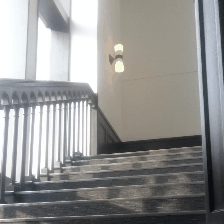

In [ ]:
display_gif(buffer,gif_name=f"{id}.gif")

In [ ]:
ae.encoder.patch_embed.patch_size,ae.encoder.patch_embed.tubelet_size

((16, 16), 2)

In [ ]:
from einops import rearrange

videos_patch = rearrange(output, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=2, p1=16, p2=16, w=14,h=14)

In [ ]:
videos_patch = videos_patch.squeeze().detach()

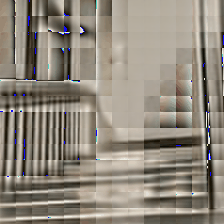

In [ ]:
display_gif(videos_patch,gif_name=f"{id}.gif")